# **Bike rental predictions based on the data provided by "Sprotten Flotte" in the time interval 03.07.2019 till 01.04.2020**

By
> Daniel Michels   
> Andrej Ponomarenko

In [4]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from keras.regularizers import l2,l1

mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

# **First we try to work with the summarized data over all stations**

In [7]:
df = pd.read_csv("/content/AlleStationen_summary.csv")
df.head()

,Num,interval,Wochentag,rent_time,bikes_diff,bikes_rented,bikes_returned,n,station,is_streiktag,is_weihnachten
0,3,2019-07-03 00:00:00,Mittwoch,0.000000,0,0,0,0,"20000,20001,20002,20003,20004,20005,20006,2000...",0,0
1,4,2019-07-03 06:00:00,Mittwoch,0.000000,0,0,0,0,"20000,20001,20002,20003,20004,20005,20006,2000...",0,0
2,5,2019-07-03 12:00:00,Mittwoch,1400.461538,-2,-14,12,26,"20000,20001,20002,20003,20004,20005,20006,2000...",0,0
3,6,2019-07-03 18:00:00,Mittwoch,7829.428571,-1,-11,10,21,"20000,20001,20002,20003,20004,20005,20006,2000...",0,0
4,7,2019-07-04 00:00:00,Donnerstag,665.250000,2,-1,3,4,"20000,20001,20002,20003,20004,20005,20006,2000...",0,0


## **At the beginning we consider univariate case with only "bikes_rented" as input time series:**

In [15]:
series = -df['bikes_rented']   # we change the numbers to be pisitive for convenience
series.index = df['interval']
series.head()

interval
2019-07-03 00:00:00     0
2019-07-03 06:00:00     0
2019-07-03 12:00:00    14
2019-07-03 18:00:00    11
2019-07-04 00:00:00     1
Name: bikes_rented, dtype: int64

**Time stamps ('interval') are every 6 hours, i.e. 4 times a day**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a419912b0>],
      dtype=object)

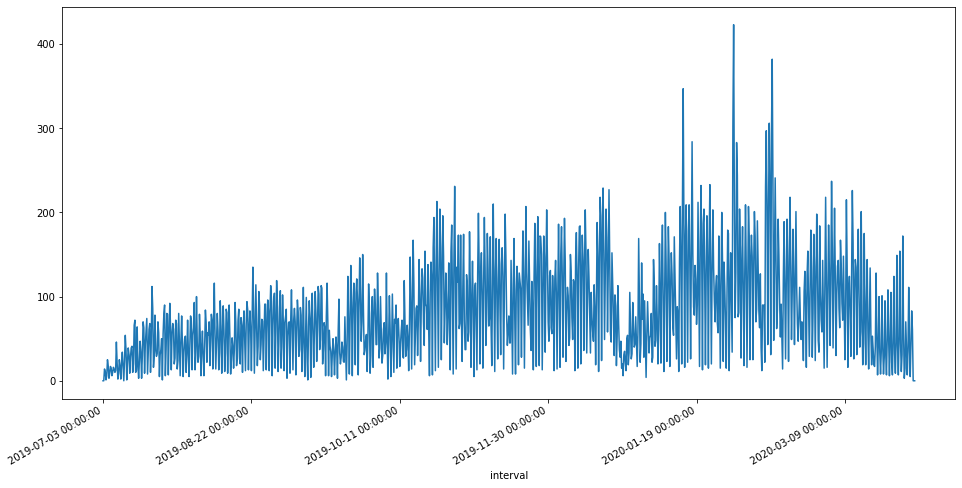

In [6]:
series.plot(subplots=True)

**Create utility function for cutting the whole time series in intervals of size = WINDOW_SIZE. The NNs below expect such interval as input and the output is the prediction of the series value on the next time stamp after this interval.**

In [13]:
WINDOW_SIZE = 7*4         # We have 4 time stamps per day, so window size = 1 Week

def windowed_data(dataset, start_index, end_index):
  data = []
  labels = []

  start_index = start_index + WINDOW_SIZE
  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(i-WINDOW_SIZE, i)
    # Reshape data from (WINDOW_SIZE,) to (WINDOW_SIZE, 1)
    #data.append(np.reshape(dataset[indices], (WINDOW_SIZE, 1)))
    data.append(dataset[indices])
    labels.append(dataset[i])
  return np.array(data), np.array(labels)

def plot_loss_function2(history, show_loss_size=100):
  loss = history.history['loss']
  valid_loss = history.history['val_loss']
  print("The achived loss={} and valid_loss={}".format(loss[-1],valid_loss[-1]))
  epochs = range(len(loss[-show_loss_size:]))
  plt.plot(epochs, loss[-show_loss_size:], 'b', label='Training Loss')
  plt.plot(epochs, valid_loss[-show_loss_size:], 'r', label='Testing Loss')
  plt.legend()
  plt.rcParams.update({'font.size': 22})
  plt.show()
  plt.rcParams.update({'font.size': 12})


**Splitting the data into trainings and validations sets:**

In [16]:
print("Total number of time stamps = ",len(series))
split_time = int(len(series)*0.8)                   # 80% training 20% test
split_time = split_time - split_time%WINDOW_SIZE    # split_time is now divisible by window_size
print("Split time = ", split_time)

Total number of time stamps =  1095
Split time =  868


**Normalization/standartization. Note: the mean and standard deviation should only be computed using the training data.**

In [9]:
series = series.values
SERIES_MEAN = series[:split_time].mean()
SERIES_STD = series[:split_time].std()
series = (series-SERIES_MEAN)/SERIES_STD

**Creating train and validation data sets by cutting the whole time series into correspondent window-sized intervals:**

In [10]:
x_train, y_train = windowed_data(series, 0, split_time)
x_val, y_val = windowed_data(series, split_time, None)

print ("Shape of trining input set = {} and validation input set = {}".format(x_train.shape, x_val.shape))
print ('First window of history:')
print (x_train[0])
print ('\n The correspondent label to this window:')
print (y_train[0])

Shape of trining input set = (840, 28) and validation input set = (199, 28)
First window of history:
[-1.34636932 -1.34636932 -1.10382845 -1.15580149 -1.32904498 -1.24242323
 -0.91326061 -1.03453105 -1.29439628 -1.19045019 -1.0518554  -1.0865041
 -1.24242323 -1.17312584 -1.06917975 -1.10382845 -1.17312584 -1.13847714
 -0.5494493  -0.98255801 -1.31172063 -1.19045019 -0.91326061 -1.0518554
 -1.31172063 -0.98255801 -0.75734148 -1.06917975]

 The correspondent label to this window:
-1.3463693249416109


**Utility for batching and shuffling the generated above sets of window+label:**

In [26]:
BATCH_SIZE = 20
BUFFER_SIZE = 1000

def create_shuffled_datasets(x_train, y_train, x_val, y_val):
  tf.keras.backend.clear_session()
  tf.random.set_seed(23)
  np.random.seed(23)

  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_set = val_set.batch(BATCH_SIZE).repeat()

  return train_set, val_set

### **The 1. attempt with 3 dense layer:**

In [17]:
simple_dense_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_shape=x_train.shape[-1:], kernel_regularizer=l2(0.1), activation="tanh"),
    tf.keras.layers.Dense(10, activation="tanh"), 
    tf.keras.layers.Dense(1),
])
sgd = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
simple_dense_model.compile(loss="mse", optimizer=sgd)

In [18]:
train_set, val_set = create_shuffled_datasets(x_train, y_train, x_val, y_val)
history = simple_dense_model.fit(train_set, epochs=100, steps_per_epoch=42 , validation_data=val_set, validation_steps=10, verbose=0)

The achived loss=0.22159449756145477 and valid_loss=0.3160494863986969


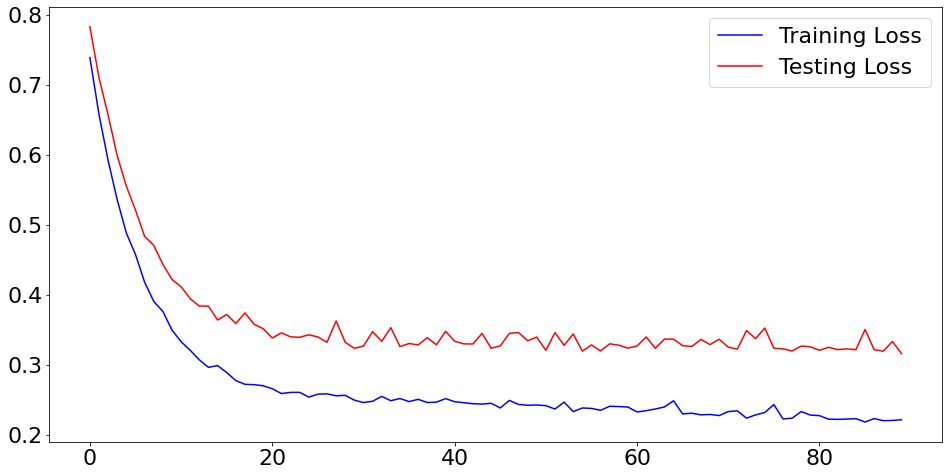

In [19]:
plot_loss_function2(history,90)

### **The 2. attempt with 1-LSTM-layer:**

In [20]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),                                             
    tf.keras.layers.LSTM(32, dropout=0.2),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam', loss='mse')

In [21]:
train_set, val_set = create_shuffled_datasets(x_train, y_train, x_val, y_val)
history = simple_lstm_model.fit(train_set, epochs=100, steps_per_epoch=42 , validation_data=val_set, validation_steps=10, verbose=0)

The achived loss=0.1888464391231537 and valid_loss=0.2803811728954315


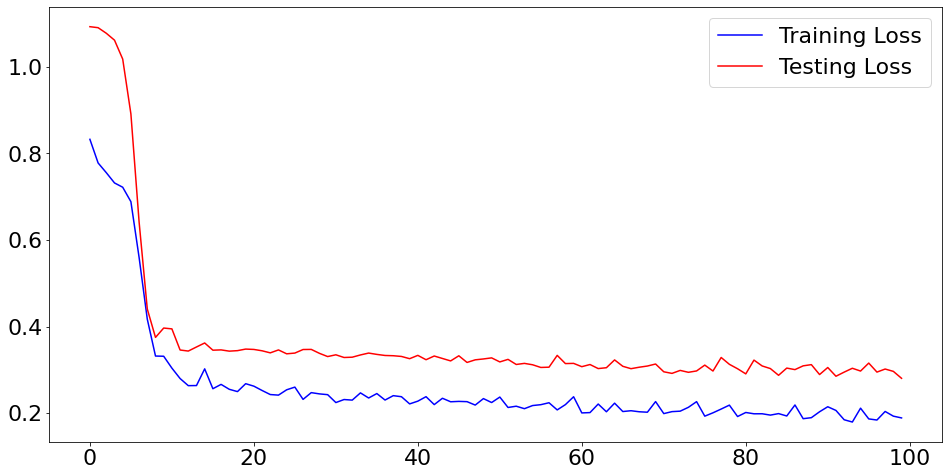

In [22]:
plot_loss_function2(history)

### **The 3. attempt with convolution and bidirectional LSTM layers:**

In [23]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
  tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding="causal", activation="relu"),
  tf.keras.layers.MaxPooling1D(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(26, dropout=0.5)),
  tf.keras.layers.Dense(1),
])

model.compile(loss="mse", #tf.keras.losses.Huber(),
              optimizer='adam', metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 52)                12272     
_________________________________________________________________
dense (Dense)                (None, 1)                 53        
Total params: 12,581
Trainable params: 12,581
Non-trainable params: 0
_________________________________________________________________


In [24]:
train_set, val_set = create_shuffled_datasets(x_train, y_train, x_val, y_val)
history = model.fit(train_set, epochs=100, steps_per_epoch=42 , validation_data=val_set, validation_steps=10, verbose=0)

The achived loss=0.1637008786201477 and valid_loss=0.2543092370033264


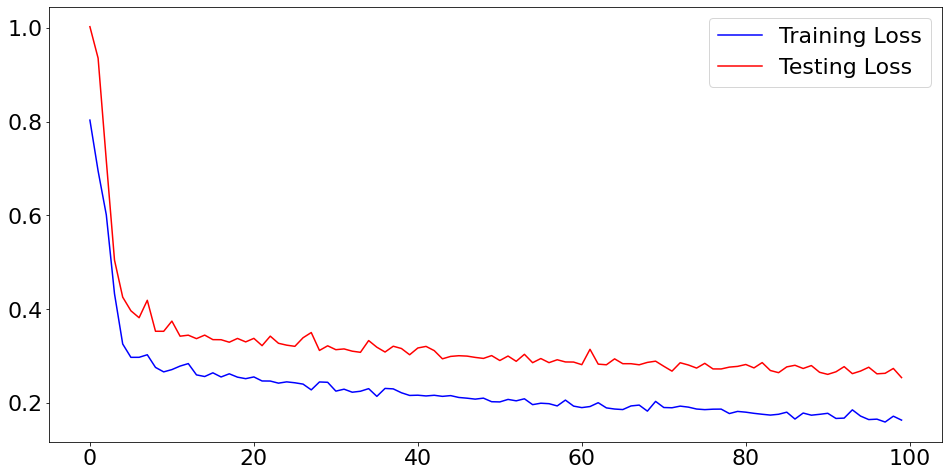

In [25]:
plot_loss_function2(history)

**Let us see the forcasting result based on the last model:**

In [46]:
#Forecasting utilities

def forecast(model, series, window_size, split_time):
    forecast = []
    for time in range(len(series) - window_size):
      forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    past = forecast[:split_time-window_size]
    forecast = forecast[split_time-window_size:]
    return np.array(past)[:, 0, 0], np.array(forecast)[:, 0, 0]

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Bikes")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [27]:
past_results, forecast_results = forecast(model, series, WINDOW_SIZE, split_time)

**First we have a look on the trainig data:**

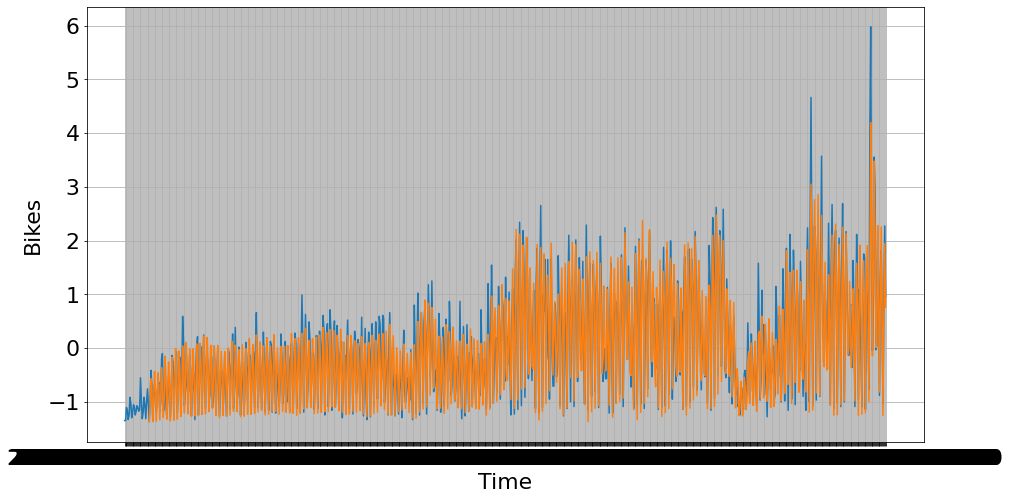

In [28]:
time=df['interval']
time_train = time[:split_time]
plt.figure(figsize=(15, 8))
plot_series(time_train, series[:split_time])
plot_series(time_train[WINDOW_SIZE:], past_results)

**And now the prediction on the testing data:**

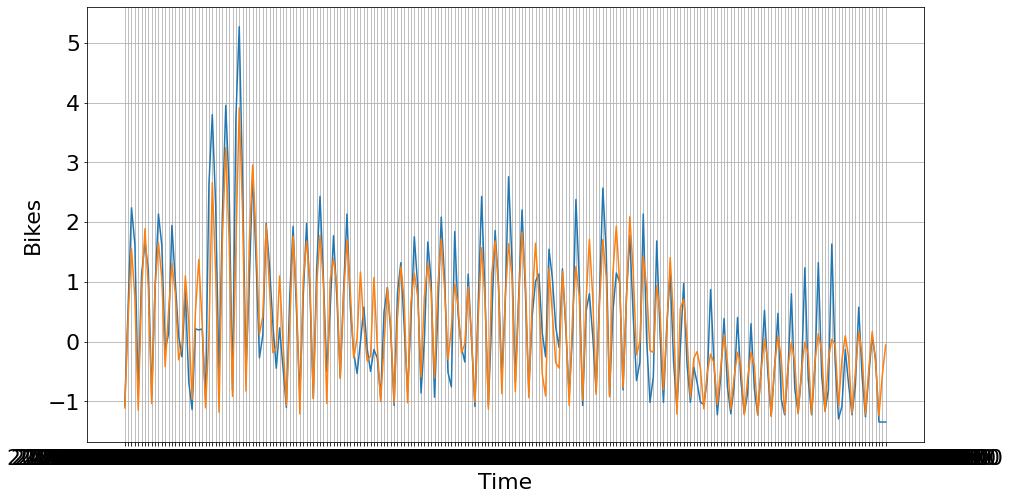

In [29]:
time_valid=time[split_time:]
plt.figure(figsize=(15, 8))
plot_series(time_valid, series[split_time:])
plot_series(time_valid, forecast_results)

**Zoom in the first week:**

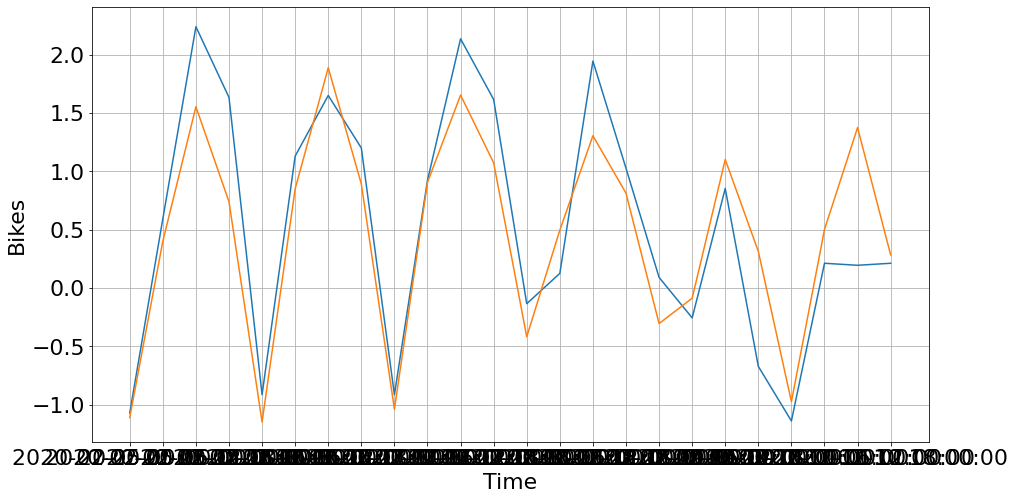

In [30]:
plt.figure(figsize=(15, 8))
plot_series(time_valid, series[split_time:], start=0, end=24)
plot_series(time_valid, forecast_results, start=0, end=24)

In [34]:
def denorm(series):
  return (series*SERIES_STD)+SERIES_MEAN

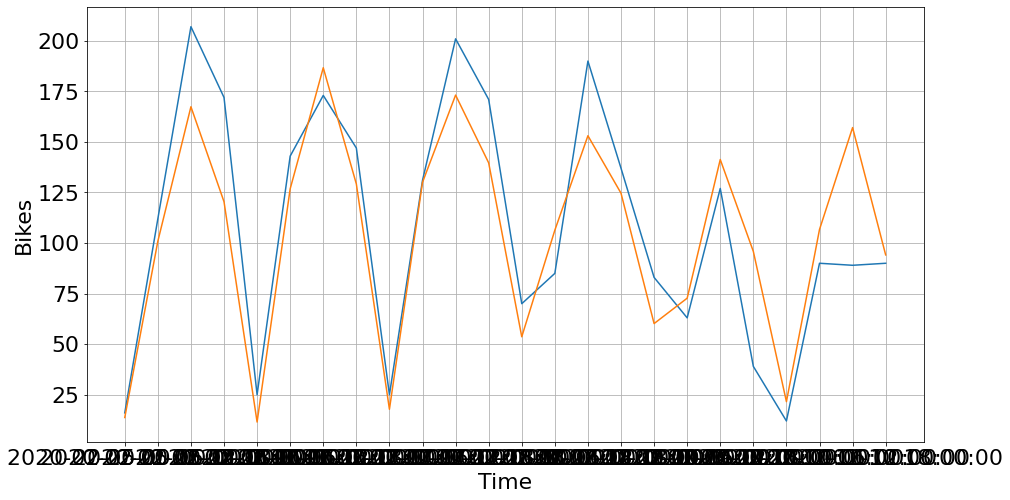

In [35]:
plt.figure(figsize=(15, 8))
plot_series(time_valid, denorm(series[split_time:]), start=0, end=24)
plot_series(time_valid, denorm(forecast_results), start=0, end=24)

## **Multivariate case with "bikes_rented" and "bikes_returned" as input time series and prediction of "bikes_rented":**

In [8]:
features_considered = ['bikes_rented', 'bikes_returned']
features = df[features_considered]
features.index = df['interval']
features.head()

,bikes_rented,bikes_returned
interval,,
2019-07-03 00:00:00,0,0
2019-07-03 06:00:00,0,0
2019-07-03 12:00:00,-14,12
2019-07-03 18:00:00,-11,10
2019-07-04 00:00:00,-1,3


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a3fbc1a20>,
      dtype=object)

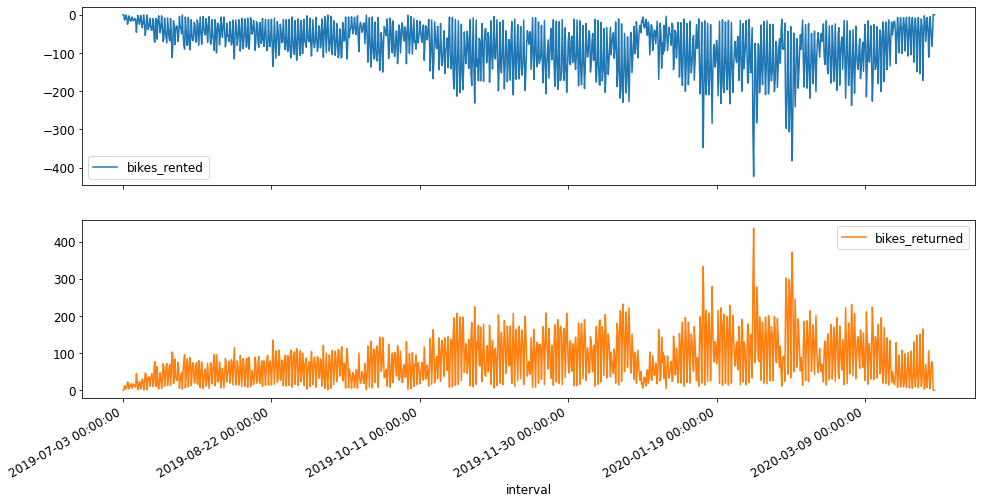

In [53]:
features.plot(subplots=True)

**Normalizing/standardizing:**

In [40]:
dataset = features.values
data_mean = dataset[:split_time].mean(axis=0)
data_std = dataset[:split_time].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [20]:
def windowed_data2(dataset, target, start_index, end_index):
  data = []
  labels = []

  start_index = start_index + WINDOW_SIZE
  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(i-WINDOW_SIZE, i)
    data.append(dataset[indices])
    labels.append(target[i])

  return np.array(data), np.array(labels)

**We want to predict the number of "bikes rented" as above:**

In [44]:
x_train2, y_train2 = windowed_data2(dataset, dataset[:, 0], 0, split_time) # target is "bikes rented"
x_val2, y_val2 = windowed_data2(dataset, dataset[:, 0], split_time, None)
print ('First window of past history : {}'.format(x_train2[0].shape))

First window of past history : (28, 2)


### **The 1. attempt with 1 layer of LSTM:**

In [50]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(28, dropout=0.2, input_shape=x_train2.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')

In [51]:
train_set, val_set = create_shuffled_datasets(x_train2, y_train2, x_val2, y_val2)
history = simple_lstm_model.fit(train_set, epochs=100, steps_per_epoch=42 , validation_data=val_set, validation_steps=10, verbose=0)

The achived loss=0.17264702916145325 and valid_loss=0.24928008019924164


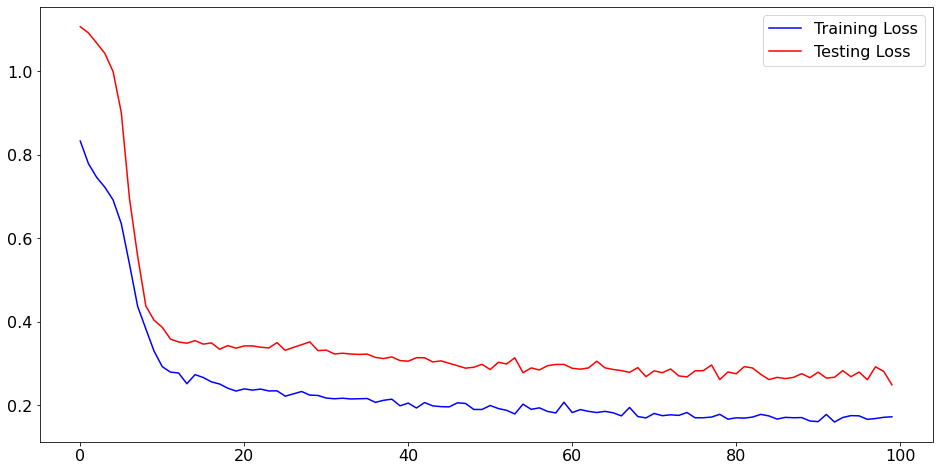

In [52]:
plot_loss_function2(history)

### **The 2. attempt with convolution and bidirectional LSTM layers:**

In [190]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding="causal", activation="relu",
                         input_shape=x_train2.shape[-2:]),
  tf.keras.layers.MaxPooling1D(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(22, dropout=0.5)), #22
  tf.keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer='adam', metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 32)            480       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 44)                9680      
_________________________________________________________________
dense (Dense)                (None, 1)                 45        
Total params: 10,205
Trainable params: 10,205
Non-trainable params: 0
_________________________________________________________________


In [191]:
train_set, val_set = create_shuffled_datasets(x_train2, y_train2, x_val2, y_val2)
history = model.fit(train_set, epochs=100, steps_per_epoch=42 , validation_data=val_set, validation_steps=10, verbose=0)

The achived loss=0.16812267899513245 and valid_loss=0.2601125240325928


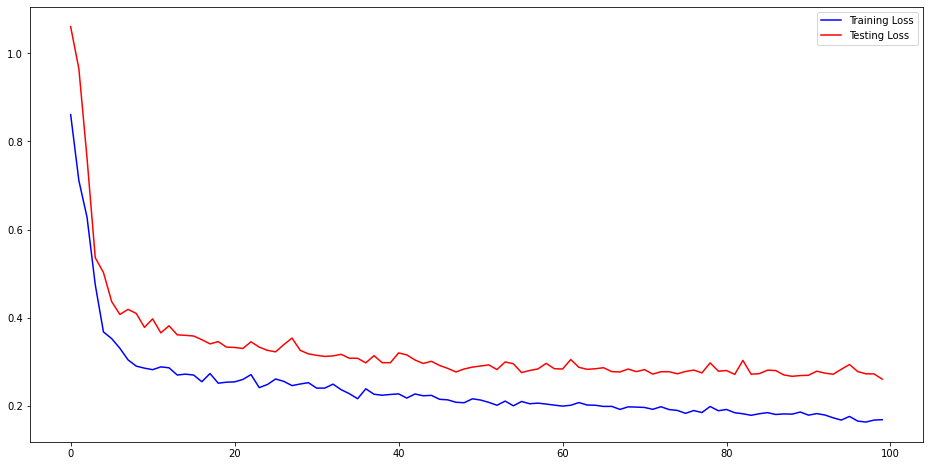

In [192]:
plot_loss_function2(history)

# **Now try to make forcasting for a specific station**

## **Multivariate case with 3 time serieses "bikes_diff", "bikes_rented" and "bikes_returned" as input and intention to predict "bikes_diff" for only one specific station:**

In [32]:
#df2 = pd.read_csv("/content/UmsteigerComplete_Summary.csv")
df2 = pd.read_csv("/content/Westring_summary.csv")
df2.head()

,Unnamed: 0,interval,Wochentag,rent_time,bikes_diff,bikes_rented,bikes_returned,n,station,is_streiktag,is_weihnachten
0,1,2019-07-02 12:00:00,Dienstag,0.0,0,0,0,0,20032,0,0
1,2,2019-07-02 18:00:00,Dienstag,0.0,0,0,0,0,20032,0,0
2,3,2019-07-03 00:00:00,Mittwoch,0.0,0,0,0,0,20032,0,0
3,4,2019-07-03 06:00:00,Mittwoch,0.0,0,0,0,0,20032,0,0
4,5,2019-07-03 12:00:00,Mittwoch,259.0,-1,-2,1,3,20032,0,0


In [33]:
features_considered = ['bikes_diff', 'bikes_rented', 'bikes_returned']
features = df2[features_considered]
features.index = df2['interval']
features.head()

,bikes_diff,bikes_rented,bikes_returned
interval,,,
2019-07-02 12:00:00,0,0,0
2019-07-02 18:00:00,0,0,0
2019-07-03 00:00:00,0,0,0
2019-07-03 06:00:00,0,0,0
2019-07-03 12:00:00,-1,-2,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f35edd1a518>,
      dtype=object)

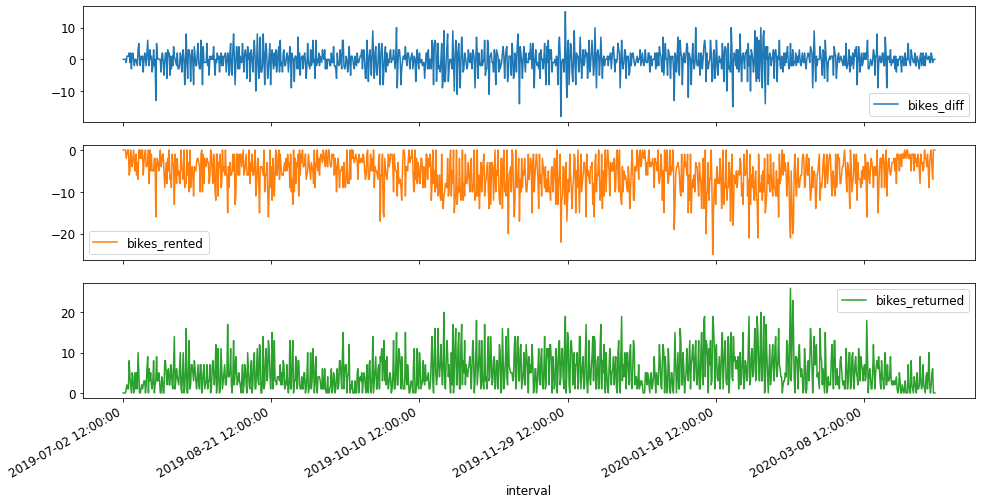

In [34]:
features.plot(subplots=True)

In [35]:
split_time = int(len(dataset)*0.8)                  # 80% training 20% test
split_time = split_time - split_time%WINDOW_SIZE  # split_time is now divisible by window_size
print("split time = ", split_time)

split time =  868


**Normalization:**

In [36]:
dataset = features.values
DATA_MEAN = dataset[:split_time].mean(axis=0)
print("Mean values:", DATA_MEAN)
DATA_STD = dataset[:split_time].std(axis=0)
print("Std. deviations:", DATA_STD)
dataset = (dataset-DATA_MEAN)/DATA_STD
print(dataset.shape)

Mean values: [-0.29262673 -5.65322581  5.36059908]
Std. deviations: [3.89192606 4.27814898 4.58485441]
(1097, 3)


In [37]:
x_train3, y_train3 = windowed_data2(dataset, dataset[:, 0], 0, split_time) # target is "bikes diff"
x_val3, y_val3 = windowed_data2(dataset, dataset[:, 0], split_time, None) #dataset[:,[1,2]]
print ('First window of past history : {}'.format(x_train3.shape))
#print(x_train3[0],y_train3[0], dataset[WINDOW_SIZE,0])

First window of past history : (840, 28, 3)


## **The 1. attempt with 3 dense layers:**

In [38]:
simple_dense_model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((-1,), input_shape=(WINDOW_SIZE,3)),
    tf.keras.layers.Dense(100, activation="tanh", kernel_regularizer=l2(0.1)), #input_shape=x_train3.shape[-1:]),
    tf.keras.layers.Dense(10, activation="tanh", kernel_regularizer=l2(0.1)),
    tf.keras.layers.Dense(1)
])
print(simple_dense_model.layers[0].output_shape)
sgd = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
simple_dense_model.compile(optimizer=sgd, loss='mse')

(None, 84)


The achived loss=0.556370735168457 and valid_loss=0.4065455496311188


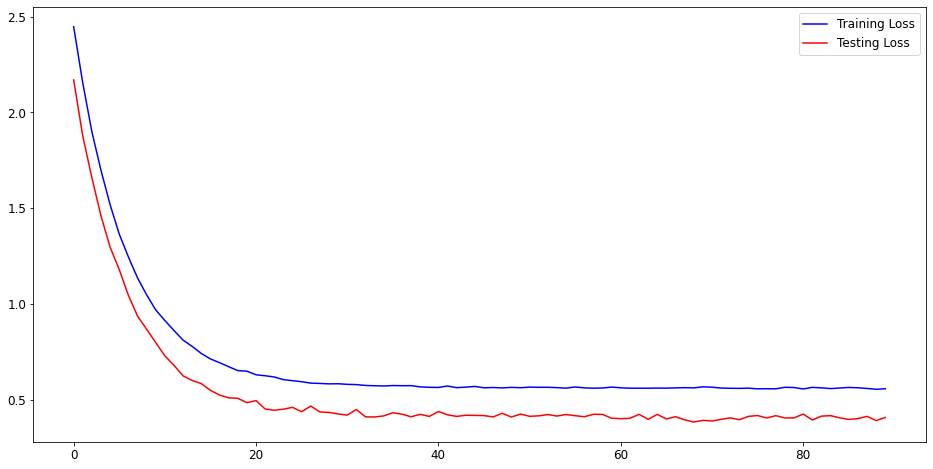

In [39]:
train_set, val_set = create_shuffled_datasets(x_train3, y_train3, x_val3, y_val3)
history = simple_dense_model.fit(train_set, epochs=100, steps_per_epoch=42 , validation_data=val_set, validation_steps=10, verbose=0)
plot_loss_function2(history,90)

## **The 2. attempt with single LSTM layer:**

In [40]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, dropout=0.3, input_shape=x_train3.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam', loss='mse')

The achived loss=0.4907168745994568 and valid_loss=0.3489721715450287


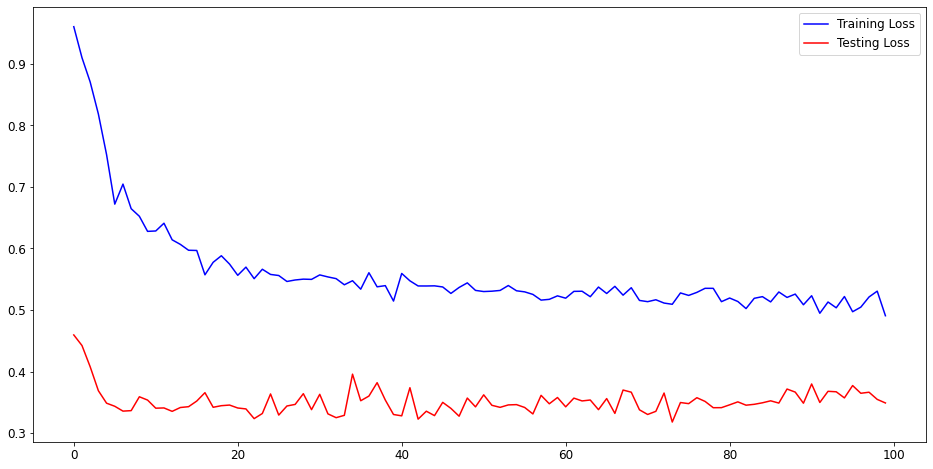

In [41]:
train_set, val_set = create_shuffled_datasets(x_train3, y_train3, x_val3, y_val3)
history = simple_lstm_model.fit(train_set, epochs=100, steps_per_epoch=42 , validation_data=val_set, validation_steps=10, verbose=0)
plot_loss_function2(history)

## **The 3. attempt with convolutional and bidirectional LSTM layers:**

In [42]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding="causal", activation="relu",
                         input_shape=x_train3.shape[-2:]),
  tf.keras.layers.MaxPooling1D(),
  #tf.keras.layers.SimpleRNN(40, dropout=0.2, return_sequences=True, input_shape=x_train3.shape[-2:]),
  #tf.keras.layers.SimpleRNN(40, dropout=0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(22, dropout=0.5)),# return_sequences=True)),
  #tf.keras.layers.LSTM(32, dropout=0.2),
  #tf.keras.layers.Dense(10, activation="tanh", kernel_regularizer=l2(0.1)),
  tf.keras.layers.Dense(1),
])

#sgd = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss="mse", optimizer='adam', metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 32)            704       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 44)                9680      
_________________________________________________________________
dense (Dense)                (None, 1)                 45        
Total params: 10,429
Trainable params: 10,429
Non-trainable params: 0
_________________________________________________________________


In [43]:
train_set, val_set = create_shuffled_datasets(x_train3, y_train3, x_val3, y_val3)
history = model.fit(train_set, epochs=100, steps_per_epoch=42 , validation_data=val_set, validation_steps=10, verbose=0)

The achived loss=0.4059849977493286 and valid_loss=0.35521039366722107


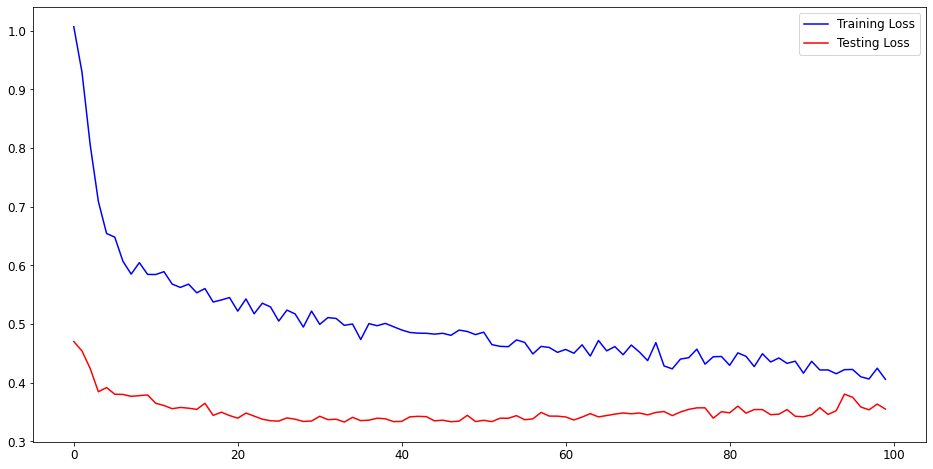

In [44]:
plot_loss_function2(history)

### **Let us have a look on the predicition made by the last model above:**

In [47]:
past_results, forecast_results = forecast(model, dataset, WINDOW_SIZE, split_time)

**Here is the training set:**

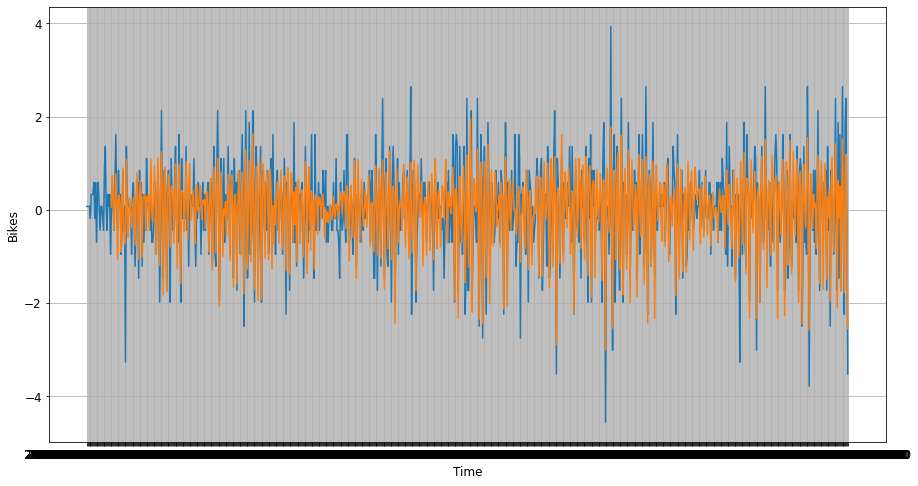

In [48]:
time=df2['interval']
time_train = time[:split_time]
plt.figure(figsize=(15, 8))
plot_series(time_train, dataset[:split_time,0])
plot_series(time_train[WINDOW_SIZE:], past_results)

**And here is the testing set:**

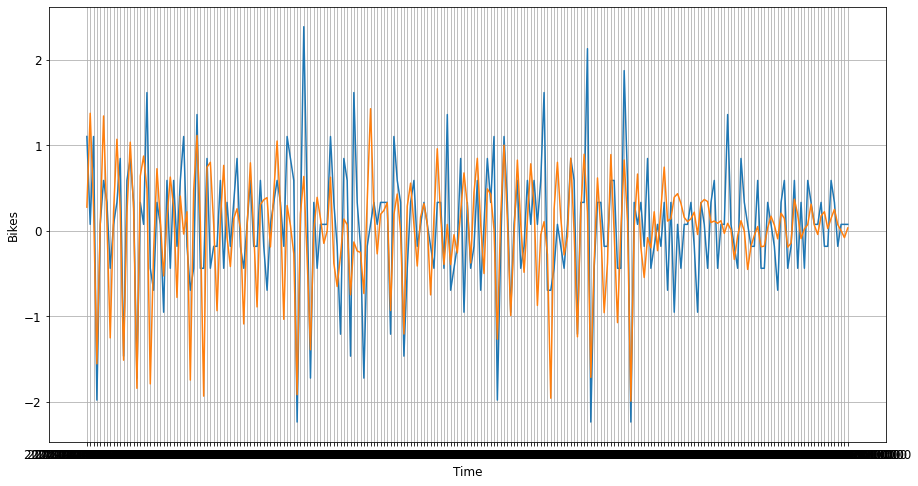

In [49]:
time_valid=time[split_time:]
plt.figure(figsize=(15, 8))
plot_series(time_valid, dataset[split_time:,0])
plot_series(time_valid, forecast_results)

In [50]:
def denorm2(dataset, dim_num):
  return (dataset*DATA_STD[dim_num])+DATA_MEAN[dim_num]

**Zoom in the first week:**

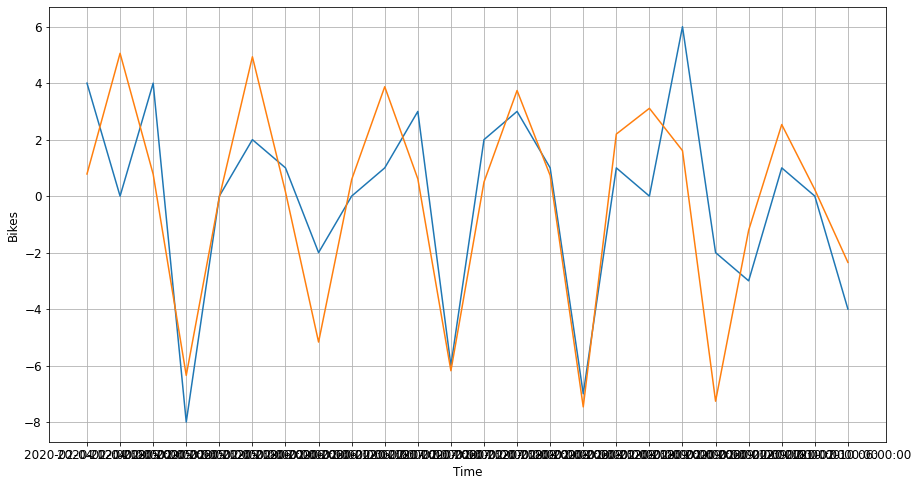

In [51]:
plt.figure(figsize=(15, 8))
plot_series(time_valid, denorm2(dataset[split_time:,0],0), start=0, end=24)
plot_series(time_valid, denorm2(forecast_results,0), start=0, end=24)